# Technical: Learning the temperature parameter

- This notebook demo will show how to use learnable temperature feature in CEBRA using rat hippocampus dataset.

- Install note: be sure you have cebra, and the demo dependencies, installed to use this notebook: 

In [ ]:
!pip install 'cebra[datasets,demos]'

In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA

from matplotlib.collections import LineCollection
import pandas as pd


- Be sure you have downloaded the data and placed `/data` from [FigShare](https://figshare.com/s/60adb075234c2cc51fa3) and into the `demo_notebooks` directory. Let's check if it's there:

In [1]:
ls

Demo_Allen.ipynb                      Demo_learnable_temperature.ipynb
Demo_cohomology.ipynb                 Demo_primate_reaching.ipynb
Demo_consistency.ipynb                Demo_primate_reaching_mse_loss.ipynb
Demo_conv-pivae.ipynb                 Demo_synthetic_exp.ipynb
Demo_decoding.ipynb                   README.rst
Demo_hippocampus.ipynb                data/
Demo_hippocampus_multisession.ipynb   rat_demo_example_output.h5
Demo_hypothesis_testing.ipynb


### Load the data:

In [2]:
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

In [6]:
max_iterations = 5000

## Fixed temperature model:
-  `temperature_mode` is set to `constant` by default, which uses a fixed temperature for a model. 
- Initialize and train a model.

In [9]:
cebra_fixed_temperature_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature_mode = 'constant',
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [10]:
cebra_fixed_temperature_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index)
fixed_temp_emb = cebra_fixed_temperature_model.transform(hippocampus_pos.neural)

_continuous_index
_discrete_index
delta
_seed
_seed


pos:  0.0898 neg:  5.4158 total:  5.5056 temperature:  1.0000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:06<00:00, 26.83it/s]


CEBRA(batch_size=512, conditional='time_delta', max_iterations=5000,
      model_architecture='offset10-model', output_dimension=3, temperature=1,
      time_offsets=10, verbose=True)

## Learnable temperature model:
- Setting `temperature_mode` to `auto` will make the temperature to be optimized during the training of a model.
- `min_temperature` is the lower bound for the tempearture. If not specified, `min_temperature` is set to asymptotic 0. 

In [42]:
cebra_learnable_temperature_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature_mode = 'auto',
                        temperature=1,
                        min_temperature = 1e-1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [43]:
cebra_learnable_temperature_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index)
learnable_temp_emb = cebra_learnable_temperature_model.transform(hippocampus_pos.neural)

_continuous_index
_discrete_index
delta
_seed
_seed


pos:  0.4400 neg:  4.2548 total:  4.6948 temperature:  0.2280: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:08<00:00, 26.58it/s]


## Visualize the loss and the temperature:

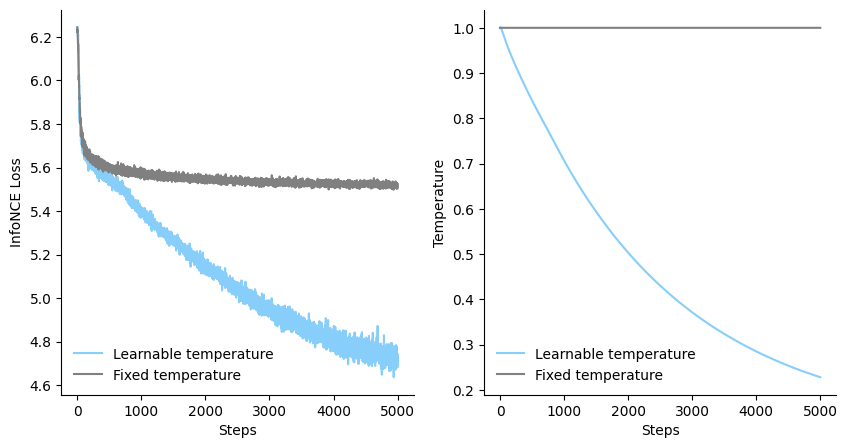

In [46]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
ax1.plot(cebra_learnable_temperature_model.state_dict_['loss'], c= 'lightskyblue', label='Learnable temperature')
ax1.plot(cebra_fixed_temperature_model.state_dict_['loss'], c='gray', label = 'Fixed temperature')
ax1.set_ylabel('InfoNCE Loss')
ax1.set_xlabel('Steps')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.legend(loc = 'lower left', frameon = False)
ax2= plt.subplot(122)
ax2.plot(cebra_learnable_temperature_model.state_dict_['log']['temperature'], c= 'lightskyblue', label='Learnable temperature')
ax2.plot(cebra_fixed_temperature_model.state_dict_['log']['temperature'], c='gray', label = 'Fixed temperature')
ax2.set_ylabel('Temperature')
ax2.set_xlabel('Steps')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.legend(loc = 'lower left', frameon = False)

## Visualize the embeddings from the models

In [47]:
def plot_hippocampus(ax, embedding, label):
    r_ind = label[:,1] == 1
    l_ind = label[:,2] == 1

    ax.scatter(embedding [r_ind,0], 
               embedding [r_ind,1], 
               embedding [r_ind,2], 
               c=label[r_ind, 0],
               cmap='cool', s=1)
    ax.scatter(embedding [l_ind,0], 
               embedding [l_ind,1], 
               embedding [l_ind,2], 
               c=label[l_ind, 0],
               cmap='viridis', s=1)
    
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    return ax


Text(0.5, 0.92, 'Learnable temperature')

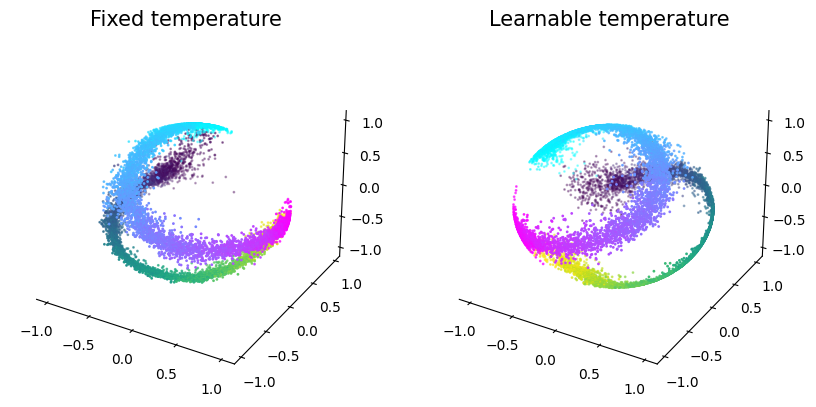

In [50]:
fig=plt.figure(figsize=(10,5))
ax1 = plt.subplot(121, projection = '3d')
ax1=plot_hippocampus(ax1, fixed_temp_emb, hippocampus_pos.continuous_index)
ax1.set_title('Fixed temperature', fontsize=15)
ax2 = plt.subplot(122, projection = '3d')
ax2=plot_hippocampus(ax2, learnable_temp_emb, hippocampus_pos.continuous_index)
ax2.set_title('Learnable temperature', fontsize=15)